In [ ]:
# Необходимые библиотеки
! pip install pandasql
! pip install sqlalchemy==1.4.46

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=dab04ebf02b61ad4f71239b9c39009db98b34356d62f4bffa879e3e70f184a54
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.24
    Uninstalling SQLAlchemy-2.0.24:
      Successfully uninstalled SQLAlchemy-2.0.24
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.46 which is incompatible.


In [ ]:
import pandas as pd
from pandasql import sqldf
from matplotlib import pyplot as plt

In [ ]:
orders = pd.read_csv("/content/drive/MyDrive/sravni/orders.csv")
user = pd.read_csv("/content/drive/MyDrive/sravni/user.csv")
sales = pd.read_csv("/content/drive/MyDrive/sravni/sales.csv")
product = pd.read_csv("/content/drive/MyDrive/sravni/product.csv")
store = pd.read_csv("/content/drive/MyDrive/sravni/store.csv")

In [ ]:
#функция для обновления строки в столбце
def update_string(row):
    updated_row = row.replace("'", '"').replace('True', 'true').replace('False', 'false')
    return updated_row

#применение функции к столбцу
orders['product_info'] = orders['product_info'].apply(update_string)

print(orders)

         order_id  order_date  user_id  store_id  \
0               1  2022-01-11       13         6   
1               2  2022-01-11       70         6   
2               3  2022-01-11       75         6   
3               4  2022-01-11      172         6   
4               5  2022-01-11      176         6   
...           ...         ...      ...       ...   
1009995   1009996  2023-11-30     9966        15   
1009996   1009997  2023-11-30     9978        15   
1009997   1009998  2023-11-30     9979        15   
1009998   1009999  2023-11-30     9984        15   
1009999   1010000  2023-11-30     9995        15   

                                              product_info  
0        [{"product_id": 3283, "product_price": 18245.9...  
1        [{"product_id": 505, "product_price": 11060.84...  
2        [{"product_id": 1546, "product_price": 3065.23...  
3        [{"product_id": 3354, "product_price": 7131.35...  
4        [{"product_id": 3595, "product_price": 13762.1...  
...      

In [ ]:
simple_query = ('''
SELECT
    user.user_id AS USER_ID_1,
    orders.order_id AS ORDER_ID_1,
    orders.order_date AS ORDER_DATE,
    SUM(CAST(json_extract(json_each.value, '$.product_price') AS REAL) * CAST(json_extract(json_each.value, '$.count') AS INTEGER)) AS ORDER_SUM,
    SUM(
        CASE
            WHEN json_extract(json_each.value, '$.comission_is_percent') = 'true'
                THEN CAST(json_extract(json_each.value, '$.product_price') AS REAL) *
                     CAST(json_extract(json_each.value, '$.product_comission') AS REAL) *
                     CAST(json_extract(json_each.value, '$.count') AS INTEGER) / 100
            ELSE
                CAST(json_extract(json_each.value, '$.product_comission') AS REAL) *
                CAST(json_extract(json_each.value, '$.count') AS INTEGER)
        END
    ) AS ORDER_REVENUE,
    SUM(CAST(json_extract(json_each.value, '$.count') AS INTEGER)) AS ORDER_QUANTITY,
    COUNT(DISTINCT json_extract(json_each.value, '$.product_price')) AS ORDER_UNIQUE_PRODUCTS,
    store.store_id AS STORE_ID
FROM
    orders
LEFT JOIN
    sales ON sales.order_id = orders.order_id
LEFT JOIN
    product ON product.product_id = orders.product_info
LEFT JOIN
    user ON user.user_id = orders.user_id
LEFT JOIN
    store ON store.store_id = orders.store_id
CROSS JOIN
    json_each(product_info)
WHERE
    sales.is_accepted AND NOT sales.is_canceled
GROUP BY
    USER_ID_1, ORDER_ID_1, ORDER_DATE;
''')
grouped_table = pd.DataFrame(sqldf(simple_query, env = None))
grouped_table.head()

,USER_ID_1,ORDER_ID_1,ORDER_DATE,ORDER_SUM,ORDER_REVENUE,ORDER_QUANTITY,ORDER_UNIQUE_PRODUCTS,STORE_ID
0,1,134226,2023-01-23,116533.447895,9240.0,9,3,6
1,1,138480,2023-01-28,6220.638261,75.0,1,1,6
2,1,145257,2023-02-05,793929.576028,85645.0,49,6,2
3,1,147008,2023-02-07,15958.779150,2000.0,1,1,1
4,1,162489,2023-02-23,13773.462937,75.0,1,1,1


Рассчитаем ключевые метрики:
1. Общая прибыль: Сумма всех комиссий по всем проданным товарам.(total_profit)
2. Средний чек: Общая сумма заказов, деленная на количество заказов.(aov,Average Order Value)
3. Среднее количество товаров в заказе: Общее количество товаров, деленное на количество заказов.(q_avg, Average Quantity per Order)
4. Конверсия: Количество успешных заказов (с оплаченными товарами) деленное на общее количество заказов.(cr, Conversion Rate)
5. ARPU (средняя выручка на пользователя): Общая выручка деленная на количество уникальных пользователей.(arpu (Average Revenue Per User))



In [ ]:
total_profit = grouped_table['ORDER_REVENUE'].sum()  #общая прибыль

aov = round(total_profit/len(grouped_table), 1)               #средний чек

q_avg = round(grouped_table['ORDER_QUANTITY'].sum()/len(grouped_table), 1)   #среднее кол-во товаров в заказе

cr = round(len(sales[(sales['is_accepted'] == True) & (sales['is_canceled'] == False)]) / len(sales) * 100, 1)  #конверсия, количество успешных заказов, деленное на общее количество

arpu = round(total_profit/grouped_table['USER_ID_1'].nunique(), 1) #средняя выручка на пользователя

In [ ]:
data = [total_profit, aov, q_avg, cr, arpu]
columns = ['Общая прибыль', 'Средний чек', 'Среднее кол-во товаров в заказе', 'Конверсия', 'Средняя выручка на пользователя']
for col, val in zip(columns, data):
    print(f"{col}: {val}")

Общая прибыль: 36507773785.0
Средний чек: 65039.5
Среднее кол-во товаров в заказе: 34.7
Конверсия: 41.9
Средняя выручка на пользователя: 3687653.9


Составим графики:
1. График продаж по времени: Покажет динамику продаж во времени.
2. График количества заказов по пользователям: Покажет, сколько заказов делает каждый пользователь.
3. График выручки по магазинам: Покажет, какие магазины приносят больше всего выручки.
4. График количества проданных товаров по категориям: Покажет, какие категории товаров наиболее популярны.

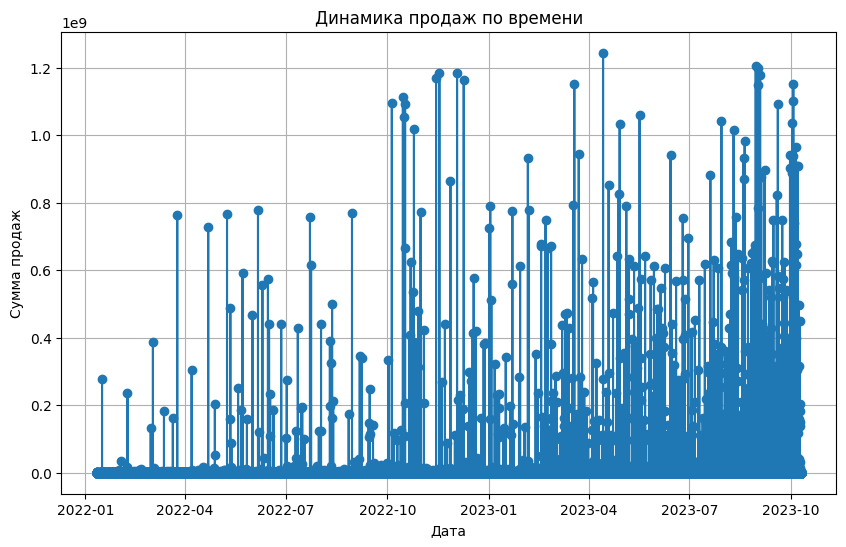

In [ ]:
#график продаж по времени:
grouped_table['ORDER_DATE'] = pd.to_datetime(grouped_table['ORDER_DATE'])

#сортируем данные по дате
df1 = grouped_table.sort_values('ORDER_DATE')

#строим график
plt.figure(figsize=(10, 6))
plt.plot(df1['ORDER_DATE'], df1['ORDER_SUM'], marker='o')
plt.title('Динамика продаж по времени')
plt.xlabel('Дата')
plt.ylabel('Сумма продаж')
plt.grid(True)
plt.show()

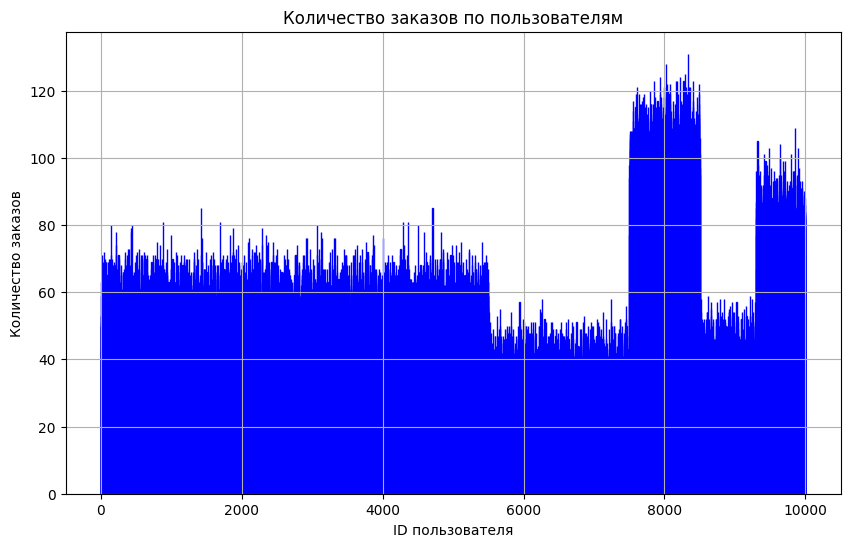

In [ ]:
#график количества заказов по пользователям:
#группируем данные по пользователям и считаем количество заказов
orders_per_user = grouped_table.groupby('USER_ID_1')['ORDER_ID_1'].count()

#строим столбчатую диаграмму
plt.figure(figsize=(10, 6))
plt.bar(orders_per_user.index, orders_per_user.values, color='skyblue', edgecolor='blue')
plt.title('Количество заказов по пользователям')
plt.xlabel('ID пользователя')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

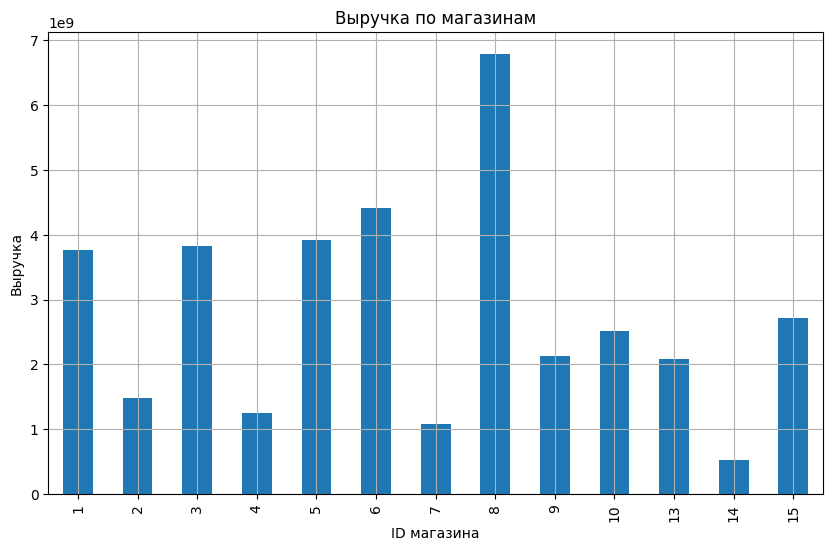

In [ ]:
# график выручки по магазинам:
# группируем данные по STORE_ID и суммируем выручку
store_revenue = grouped_table.groupby('STORE_ID')['ORDER_REVENUE'].sum()

# строим график
plt.figure(figsize=(10, 6))
store_revenue.plot(kind='bar')
plt.title('Выручка по магазинам')
plt.xlabel('ID магазина')
plt.ylabel('Выручка')
plt.grid(True)
plt.show()

In [117]:
grouped_table.to_excel('output_3_1.xlsx')

#загружаем файл
from google.colab import files
files.download('output_3_1.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>